In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
ev_signals = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-signals.csv', 
                header = 0, index_col = 0)
grid_signals = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-grid-signals.csv', 
                header = 0, index_col = 0)

In [8]:
ev_signals.iloc[0].head()

2017-01-01 00:00:00    0.005
2017-01-01 00:15:00    0.005
2017-01-01 00:30:00    0.005
2017-01-01 00:45:00    0.005
2017-01-01 01:00:00    0.005
Name: 26.0, dtype: float64

In [46]:
def make_training_set(power_series, aggregate_series, min_off_duration = 0, min_on_duration = 3, n_pad = 2, sample_length=32):
    
    signatures = []
    signals = []
    power_series.index = pd.to_datetime(power_series.index)
    off_duration = 0
    on_duration = 0

    padding = power_series.index[1] - power_series.index[0]
    
    for i in range(len(power_series.index)):
        time = power_series.index[i]
        
        if power_series.loc[time] > 0.5:
            on_duration +=1
            off_duration = 0

        else:
            if off_duration >= min_off_duration and on_duration > min_on_duration and on_duration < sample_length:
                diff = sample_length - on_duration
#                 pad_b = int(np.floor(diff/2))
#                 pad_f = int(np.ceil(diff/2))
                
                pad_b = np.random.randint(diff)
                pad_f = diff-pad_b
            
                signature = np.zeros(sample_length)

                signature[pad_b:pad_b+on_duration] += power_series.iloc[i-on_duration:i]
                
                signal = aggregate_series[i-(on_duration+pad_b):i+pad_f]
                    
                if len(signal) != len(signature):

                    signal = np.zeros(sample_length)
                    signature = np.zeros(sample_length)

                assert len(signal) == len(signature)
                
                signals.append(signal)
                signatures.append(signature)
                
            off_duration += 1
            on_duration = 0
            
    return np.array(signatures), np.array(signals) , pd.Series(signature_times)

def make_syntethic_data(signatures, aggregate_series, ev_series, n_data=5000, sample_length=32):
    syntethic_X = np.zeros((n_data,sample_length))
    syntethic_y = np.zeros((n_data,sample_length))
    aggregate_series.index = pd.to_datetime(aggregate_series.index)
    
    ev_times = pd.to_datetime(ev_series.index[np.where(ev_series > 0.5)])
    
    i = 0
    while i < n_data:
        dice1 = np.random.randint(len(aggregate_series) - sample_length)
        dice2 = np.random.randint(len(signatures))
        
        signature = signatures[dice2]
        agg_signal = aggregate_series.iloc[dice1:dice1+sample_length]
        
        if np.in1d(agg_signal.index, ev_times).any():
            continue
            
        syntethic_X[i] += agg_signal + signature
        syntethic_y[i] += signature 
        i+=1
        
    return syntethic_X, syntethic_y
        

In [45]:
np.in1d(np.arange(5),np.ones(5)*4, invert=True)

array([ True,  True,  True,  True, False], dtype=bool)

In [17]:
sample_length = 32
signatures = np.zeros((1,sample_length))
signals = np.zeros((1,sample_length))
ev_times = []

for house in tqdm(ev_signals.index):
    house_signatures, house_signals, house_ev_times = make_training_set(ev_signals.loc[house], grid_signals.loc[house], min_on_duration=6, n_pad=2, sample_length=sample_length)
    
    if house_signals.shape[0] != 0:
        signals = np.vstack([signals,house_signals])
        signatures = np.vstack([signatures, house_signatures])
        ev_times.append(house_ev_times)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [01:10<00:00,  1.63s/it]


In [47]:
syntethic_signals = np.zeros((1,sample_length))
syntethic_signatures = np.zeros((1,sample_length))

for house in tqdm(ev_signals.index):
    house_X, house_y = make_syntethic_data(signatures, grid_signals.loc[house], ev_signals.loc[house])
    syntethic_signals = np.vstack([syntethic_signals, house_X])
    syntethic_signatures = np.vstack([syntethic_signatures, house_y])

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [03:56<00:00,  5.50s/it]


In [48]:
signals = np.vstack([signals,syntethic_signals])
signatures = np.vstack([signatures,syntethic_signatures])

In [98]:
pd.DataFrame(signals).to_csv('training_data_X.csv')
pd.DataFrame(signatures).to_csv('training_data_y.csv')
print(signals.shape, signatures.shape)

(220013, 32) (220013, 32)


In [83]:
fig_path = 'C:/Users/bfesc/Documents/Master_thesis/figs/neural_nets/'

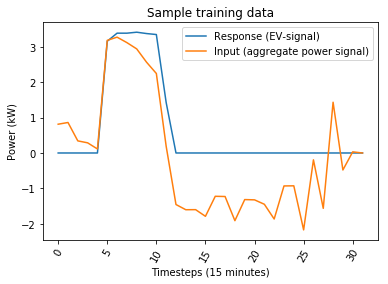

In [93]:
dice = np.random.randint(len(signatures))
plt.plot(syntethic_signatures[dice], label="Response (EV-signal)")
plt.plot(syntethic_signals[dice], label="Input (aggregate power signal)")
plt.xticks(rotation=60)
plt.title("Sample training data")
plt.xlabel("Timesteps (15 minutes)")
plt.ylabel("Power (kW)")
plt.legend()
plt.savefig(fig_path + 'training_data_example.pdf')
plt.show()

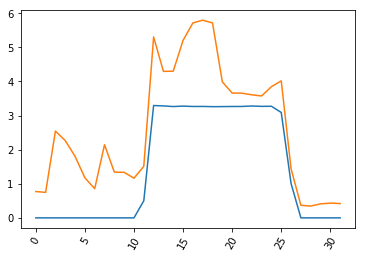

In [97]:
dice = np.random.randint(len(signatures))
plt.plot(signatures[dice])
plt.plot(signals[dice])
plt.xticks(rotation=60)
plt.show()

In [99]:
n_samples = range(len(signals))
new_signatures = np.zeros((1,sample_length))
new_signals = np.zeros((1,sample_length))

for i in tqdm(n_samples):
    dice_1 = np.random.randint(len(grid_signals.index))
    house = grid_signals.iloc[dice_1]
    
    dice_2 = np.random.randint(len(house) - (sample_length))
    
    new_signal = house.iloc[dice_2:dice_2+sample_length]
    new_signature = np.zeros(sample_length) 
    
    new_signatures = np.vstack([new_signatures,new_signature])
    new_signals = np.vstack([new_signals,new_signal])
    
    if i%int(len(signals)/25) == 0:
        signals = np.vstack([signals,new_signals])
        signatures = np.vstack([signatures,new_signatures])
        new_signatures = np.zeros((1,sample_length))
        new_signals = np.zeros((1,sample_length))
    
signals = np.vstack([signals,new_signals])
signatures = np.vstack([signatures,new_signatures])

100%|█████████████████████████████████████████████████████████████████████████| 220013/220013 [06:07<00:00, 598.94it/s]


In [100]:
print(signatures.shape,signals.shape)

(440114, 32) (440114, 32)


In [101]:
pd.DataFrame(signatures).to_csv('sliding_window_y.csv')
pd.DataFrame(signals).to_csv('sliding_window_X.csv')


This is the training data for the autoencoder

In [102]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [103]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
set_session(tf.Session(config=config))

In [104]:
from keras.models import Sequential
from keras.layers import Conv1D,Input,Dense,Flatten
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
signals = pd.read_csv('sliding_window_X.csv', index_col=0)
signatures = pd.read_csv('sliding_window_y.csv', index_col=0)

In [4]:
signals = np.asarray(signals)
signatures = np.asarray(signatures)

In [105]:
sample_length = 32

In [120]:
X = signals[:,:,np.newaxis]
y = signatures[:,:,np.newaxis]

mean = X.mean(axis=1).reshape((X.shape[0],1,1))
#mean = 0.0
X = X - mean
sd = X.std(axis=1).mean()
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X /= sd
print("Mean: ", X.mean())
print("Std: ", X.std())


Mean:  2.10341833382e-19
Std:  1.19218530451


In [107]:
normalization_params = pd.DataFrame([[mean,sd]],columns=['mean','sd'])
normalization_params.to_csv('normalization_params_dAE.csv')

In [108]:
layer1 = Conv1D(filters=8, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='same', strides=1)
layer1_b = Flatten()
layer2 = Dense(units=(sample_length-3)*8,activation='relu')
layer3 = Dense(units=64,activation='relu')
layer4 = Dense(units=(sample_length-3)*8,activation='relu')
layer5 = Conv1D(filters=1,kernel_size=4,activation='linear',padding='same', strides=1)

model = Sequential()

model.add(layer1)
#model.add(layer1_b)
model.add(layer2)
model.add(layer3)
model.add(layer4)
model.add(layer5)

In [110]:
with tf.device('/cpu:0'):
    model.compile(optimizer='adam', # try with adam?
                  loss='mean_squared_error',
                  metrics=['mae'])

    training_history = model.fit(X, y, batch_size=128,verbose=1,epochs=4, validation_split=0.1)

Train on 396102 samples, validate on 44012 samples
Epoch 1/4


 18560/396102 [>.............................] - ETA: 25:16 - loss: 1.7234 - mean_absolute_error: 0.57 - ETA: 14:35 - loss: 1.2969 - mean_absolute_error: 0.50 - ETA: 11:14 - loss: 1.1720 - mean_absolute_error: 0.48 - ETA: 9:22 - loss: 1.2352 - mean_absolute_error: 0.4978 - ETA: 8:18 - loss: 1.2472 - mean_absolute_error: 0.500 - ETA: 7:35 - loss: 1.1806 - mean_absolute_error: 0.491 - ETA: 7:04 - loss: 1.2538 - mean_absolute_error: 0.506 - ETA: 6:38 - loss: 1.3023 - mean_absolute_error: 0.523 - ETA: 6:21 - loss: 1.2482 - mean_absolute_error: 0.518 - ETA: 6:08 - loss: 1.2061 - mean_absolute_error: 0.513 - ETA: 5:56 - loss: 1.1655 - mean_absolute_error: 0.507 - ETA: 5:47 - loss: 1.1588 - mean_absolute_error: 0.505 - ETA: 5:39 - loss: 1.1392 - mean_absolute_error: 0.501 - ETA: 5:31 - loss: 1.1305 - mean_absolute_error: 0.497 - ETA: 5:29 - loss: 1.1430 - mean_absolute_error: 0.500 - ETA: 5:24 - loss: 1.1922 - mean_absolute_error: 0.507 - ETA: 5:20 - loss: 1.1985 - mean_absolute_error: 0.509 

 37248/396102 [=>............................] - ETA: 4:05 - loss: 1.1707 - mean_absolute_error: 0.489 - ETA: 4:05 - loss: 1.1717 - mean_absolute_error: 0.489 - ETA: 4:04 - loss: 1.1724 - mean_absolute_error: 0.489 - ETA: 4:04 - loss: 1.1738 - mean_absolute_error: 0.489 - ETA: 4:04 - loss: 1.1743 - mean_absolute_error: 0.489 - ETA: 4:04 - loss: 1.1724 - mean_absolute_error: 0.489 - ETA: 4:04 - loss: 1.1729 - mean_absolute_error: 0.489 - ETA: 4:03 - loss: 1.1729 - mean_absolute_error: 0.489 - ETA: 4:03 - loss: 1.1743 - mean_absolute_error: 0.490 - ETA: 4:03 - loss: 1.1757 - mean_absolute_error: 0.490 - ETA: 4:03 - loss: 1.1732 - mean_absolute_error: 0.490 - ETA: 4:03 - loss: 1.1712 - mean_absolute_error: 0.489 - ETA: 4:02 - loss: 1.1705 - mean_absolute_error: 0.489 - ETA: 4:02 - loss: 1.1727 - mean_absolute_error: 0.489 - ETA: 4:02 - loss: 1.1705 - mean_absolute_error: 0.489 - ETA: 4:03 - loss: 1.1691 - mean_absolute_error: 0.489 - ETA: 4:03 - loss: 1.1668 - mean_absolute_error: 0.488 -

 55936/396102 [===>..........................] - ETA: 3:57 - loss: 1.1479 - mean_absolute_error: 0.484 - ETA: 3:57 - loss: 1.1475 - mean_absolute_error: 0.484 - ETA: 3:57 - loss: 1.1467 - mean_absolute_error: 0.484 - ETA: 3:57 - loss: 1.1495 - mean_absolute_error: 0.484 - ETA: 3:57 - loss: 1.1494 - mean_absolute_error: 0.484 - ETA: 3:57 - loss: 1.1510 - mean_absolute_error: 0.485 - ETA: 3:57 - loss: 1.1510 - mean_absolute_error: 0.485 - ETA: 3:56 - loss: 1.1509 - mean_absolute_error: 0.485 - ETA: 3:56 - loss: 1.1510 - mean_absolute_error: 0.485 - ETA: 3:56 - loss: 1.1513 - mean_absolute_error: 0.485 - ETA: 3:56 - loss: 1.1522 - mean_absolute_error: 0.485 - ETA: 3:56 - loss: 1.1533 - mean_absolute_error: 0.485 - ETA: 3:56 - loss: 1.1523 - mean_absolute_error: 0.485 - ETA: 3:55 - loss: 1.1522 - mean_absolute_error: 0.485 - ETA: 3:55 - loss: 1.1522 - mean_absolute_error: 0.485 - ETA: 3:55 - loss: 1.1515 - mean_absolute_error: 0.485 - ETA: 3:55 - loss: 1.1525 - mean_absolute_error: 0.485 -

 74624/396102 [====>.........................] - ETA: 3:55 - loss: 1.1551 - mean_absolute_error: 0.484 - ETA: 3:55 - loss: 1.1567 - mean_absolute_error: 0.484 - ETA: 3:55 - loss: 1.1566 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1566 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1556 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1560 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1562 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1567 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1572 - mean_absolute_error: 0.484 - ETA: 3:54 - loss: 1.1587 - mean_absolute_error: 0.485 - ETA: 3:54 - loss: 1.1579 - mean_absolute_error: 0.485 - ETA: 3:54 - loss: 1.1577 - mean_absolute_error: 0.484 - ETA: 3:53 - loss: 1.1577 - mean_absolute_error: 0.485 - ETA: 3:53 - loss: 1.1575 - mean_absolute_error: 0.484 - ETA: 3:53 - loss: 1.1573 - mean_absolute_error: 0.484 - ETA: 3:53 - loss: 1.1573 - mean_absolute_error: 0.484 - ETA: 3:53 - loss: 1.1576 - mean_absolute_error: 0.484 -

 93312/396102 [======>.......................] - ETA: 3:37 - loss: 1.1521 - mean_absolute_error: 0.483 - ETA: 3:37 - loss: 1.1527 - mean_absolute_error: 0.483 - ETA: 3:37 - loss: 1.1527 - mean_absolute_error: 0.483 - ETA: 3:37 - loss: 1.1525 - mean_absolute_error: 0.483 - ETA: 3:37 - loss: 1.1530 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1529 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1525 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1528 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1525 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1520 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1519 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1512 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1505 - mean_absolute_error: 0.483 - ETA: 3:36 - loss: 1.1507 - mean_absolute_error: 0.483 - ETA: 3:35 - loss: 1.1504 - mean_absolute_error: 0.483 - ETA: 3:35 - loss: 1.1500 - mean_absolute_error: 0.483 - ETA: 3:35 - loss: 1.1494 - mean_absolute_error: 0.483 -

112000/396102 [=======>......................] - ETA: 3:21 - loss: 1.1393 - mean_absolute_error: 0.480 - ETA: 3:21 - loss: 1.1387 - mean_absolute_error: 0.480 - ETA: 3:21 - loss: 1.1386 - mean_absolute_error: 0.480 - ETA: 3:21 - loss: 1.1390 - mean_absolute_error: 0.480 - ETA: 3:21 - loss: 1.1385 - mean_absolute_error: 0.480 - ETA: 3:21 - loss: 1.1378 - mean_absolute_error: 0.480 - ETA: 3:21 - loss: 1.1377 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1371 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1370 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1375 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1369 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1368 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1366 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1366 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1366 - mean_absolute_error: 0.479 - ETA: 3:20 - loss: 1.1372 - mean_absolute_error: 0.480 - ETA: 3:20 - loss: 1.1376 - mean_absolute_error: 0.480 -

130688/396102 [========>.....................] - ETA: 3:07 - loss: 1.1297 - mean_absolute_error: 0.477 - ETA: 3:07 - loss: 1.1293 - mean_absolute_error: 0.477 - ETA: 3:07 - loss: 1.1295 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1297 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1299 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1297 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1292 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1293 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1289 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1290 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1291 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1289 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1291 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1288 - mean_absolute_error: 0.477 - ETA: 3:06 - loss: 1.1287 - mean_absolute_error: 0.477 - ETA: 3:05 - loss: 1.1286 - mean_absolute_error: 0.477 - ETA: 3:05 - loss: 1.1282 - mean_absolute_error: 0.477 -

149376/396102 [==========>...................] - ETA: 2:53 - loss: 1.1258 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1255 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1258 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1257 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1256 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1261 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1259 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1258 - mean_absolute_error: 0.475 - ETA: 2:53 - loss: 1.1257 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1251 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1251 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1255 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1249 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1246 - mean_absolute_error: 0.475 - ETA: 2:52 - loss: 1.1248 - mean_absolute_error: 0.475 -

168064/396102 [===========>..................] - ETA: 2:41 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1255 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1255 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:40 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:39 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:39 - loss: 1.1258 - mean_absolute_error: 0.475 - ETA: 2:39 - loss: 1.1259 - mean_absolute_error: 0.475 - ETA: 2:39 - loss: 1.1261 - mean_absolute_error: 0.475 - ETA: 2:39 - loss: 1.1261 - mean_absolute_error: 0.475 -

186752/396102 [=============>................] - ETA: 2:28 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1251 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1252 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:27 - loss: 1.1254 - mean_absolute_error: 0.475 - ETA: 2:26 - loss: 1.1250 - mean_absolute_error: 0.475 - ETA: 2:26 - loss: 1.1253 - mean_absolute_error: 0.475 - ETA: 2:26 - loss: 1.1258 - mean_absolute_error: 0.475 - ETA: 2:26 - loss: 1.1261 - mean_absolute_error: 0.475 - ETA: 2:26 - loss: 1.1265 - mean_absolute_error: 0.475 -

205440/396102 [==============>...............] - ETA: 2:15 - loss: 1.1289 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1287 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1289 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1286 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1286 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1286 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1285 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1285 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1285 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1285 - mean_absolute_error: 0.475 - ETA: 2:15 - loss: 1.1286 - mean_absolute_error: 0.475 - ETA: 2:14 - loss: 1.1284 - mean_absolute_error: 0.475 - ETA: 2:14 - loss: 1.1284 - mean_absolute_error: 0.475 - ETA: 2:14 - loss: 1.1285 - mean_absolute_error: 0.475 - ETA: 2:14 - loss: 1.1288 - mean_absolute_error: 0.475 - ETA: 2:14 - loss: 1.1294 - mean_absolute_error: 0.475 - ETA: 2:14 - loss: 1.1295 - mean_absolute_error: 0.475 -

224128/396102 [===============>..............] - ETA: 2:03 - loss: 1.1262 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1261 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1262 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1260 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1260 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1259 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1258 - mean_absolute_error: 0.474 - ETA: 2:03 - loss: 1.1262 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1263 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1266 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1265 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1264 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1264 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1264 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1265 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1266 - mean_absolute_error: 0.474 - ETA: 2:02 - loss: 1.1264 - mean_absolute_error: 0.474 -

242816/396102 [=================>............] - ETA: 1:51 - loss: 1.1261 - mean_absolute_error: 0.473 - ETA: 1:51 - loss: 1.1261 - mean_absolute_error: 0.473 - ETA: 1:51 - loss: 1.1259 - mean_absolute_error: 0.473 - ETA: 1:51 - loss: 1.1258 - mean_absolute_error: 0.473 - ETA: 1:51 - loss: 1.1259 - mean_absolute_error: 0.473 - ETA: 1:51 - loss: 1.1258 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1257 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1257 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1257 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1257 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1257 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1257 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1256 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1255 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1253 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1254 - mean_absolute_error: 0.473 - ETA: 1:50 - loss: 1.1253 - mean_absolute_error: 0.473 -

261504/396102 [==================>...........] - ETA: 1:39 - loss: 1.1242 - mean_absolute_error: 0.472 - ETA: 1:39 - loss: 1.1241 - mean_absolute_error: 0.472 - ETA: 1:39 - loss: 1.1242 - mean_absolute_error: 0.472 - ETA: 1:39 - loss: 1.1240 - mean_absolute_error: 0.472 - ETA: 1:39 - loss: 1.1240 - mean_absolute_error: 0.472 - ETA: 1:39 - loss: 1.1241 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1241 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1240 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1244 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1245 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1246 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1246 - mean_absolute_error: 0.472 - ETA: 1:38 - loss: 1.1249 - mean_absolute_error: 0.473 - ETA: 1:38 - loss: 1.1251 - mean_absolute_error: 0.473 - ETA: 1:38 - loss: 1.1253 - mean_absolute_error: 0.473 - ETA: 1:38 - loss: 1.1253 - mean_absolute_error: 0.473 - ETA: 1:38 - loss: 1.1252 - mean_absolute_error: 0.473 -

280192/396102 [====================>.........] - ETA: 1:27 - loss: 1.1247 - mean_absolute_error: 0.472 - ETA: 1:27 - loss: 1.1248 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1250 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1251 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1250 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1250 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1249 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1250 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1249 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1249 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1249 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1250 - mean_absolute_error: 0.472 - ETA: 1:26 - loss: 1.1252 - mean_absolute_error: 0.473 - ETA: 1:25 - loss: 1.1252 - mean_absolute_error: 0.472 - ETA: 1:25 - loss: 1.1251 - mean_absolute_error: 0.472 - ETA: 1:25 - loss: 1.1252 - mean_absolute_error: 0.472 - ETA: 1:25 - loss: 1.1253 - mean_absolute_error: 0.473 -

298880/396102 [=====================>........] - ETA: 1:14 - loss: 1.1243 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1243 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1242 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1240 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1240 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:14 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1237 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1237 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1237 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1238 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1237 - mean_absolute_error: 0.472 - ETA: 1:13 - loss: 1.1238 - mean_absolute_error: 0.472 -

318080/396102 [=======================>......] - ETA: 1:02 - loss: 1.1212 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1214 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1214 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1213 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1213 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1215 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1215 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1215 - mean_absolute_error: 0.471 - ETA: 1:02 - loss: 1.1215 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1215 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1218 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1217 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1217 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1216 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1218 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1218 - mean_absolute_error: 0.471 - ETA: 1:01 - loss: 1.1217 - mean_absolute_error: 0.471 -

337408/396102 [========================>.....] - ETA: 50s - loss: 1.1236 - mean_absolute_error: 0.47 - ETA: 50s - loss: 1.1235 - mean_absolute_error: 0.47 - ETA: 50s - loss: 1.1236 - mean_absolute_error: 0.47 - ETA: 50s - loss: 1.1237 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1237 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1235 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1235 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1234 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1235 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1234 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1233 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1233 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1234 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1233 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1234 - mean_absolute_error: 0.47 - ETA: 49s - loss: 1.1234 - mean_absolute_error: 0.47 - ETA: 48s - loss: 1.1233 - mean_absolute_error: 0.47 - ETA: 48s - loss: 1.1232 - mean_ab

356736/396102 [==========================>...] - ETA: 37s - loss: 1.1222 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1221 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1220 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1221 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1220 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1222 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1222 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1221 - mean_absolute_error: 0.47 - ETA: 37s - loss: 1.1220 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1221 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1220 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1220 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1219 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1217 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1218 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1217 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1217 - mean_absolute_error: 0.47 - ETA: 36s - loss: 1.1218 - mean_ab

376064/396102 [===========================>..] - ETA: 25s - loss: 1.1209 - mean_absolute_error: 0.47 - ETA: 25s - loss: 1.1209 - mean_absolute_error: 0.47 - ETA: 25s - loss: 1.1207 - mean_absolute_error: 0.47 - ETA: 25s - loss: 1.1207 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1207 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1209 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1209 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1208 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1208 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1206 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1205 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1204 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1204 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1203 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1203 - mean_absolute_error: 0.47 - ETA: 24s - loss: 1.1203 - mean_absolute_error: 0.47 - ETA: 23s - loss: 1.1202 - mean_absolute_error: 0.47 - ETA: 23s - loss: 1.1202 - mean_ab

395392/396102 [============================>.] - ETA: 12s - loss: 1.1185 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1184 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1182 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1182 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1181 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1180 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1179 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1181 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1181 - mean_absolute_error: 0.46 - ETA: 12s - loss: 1.1180 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1180 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1180 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1180 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1178 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1179 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1179 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1178 - mean_absolute_error: 0.46 - ETA: 11s - loss: 1.1178 - mean_ab

396102/396102 [==============================] - ETA: 0s - loss: 1.1148 - mean_absolute_error: 0.468 - ETA: 0s - loss: 1.1148 - mean_absolute_error: 0.468 - ETA: 0s - loss: 1.1148 - mean_absolute_error: 0.468 - ETA: 0s - loss: 1.1147 - mean_absolute_error: 0.468 - ETA: 0s - loss: 1.1146 - mean_absolute_error: 0.468 - 263s 665us/step - loss: 1.1146 - mean_absolute_error: 0.4687 - val_loss: 0.9802 - val_mean_absolute_error: 0.3928
Epoch 2/4


 18688/396102 [>.............................] - ETA: 4:54 - loss: 1.1322 - mean_absolute_error: 0.454 - ETA: 4:29 - loss: 1.1912 - mean_absolute_error: 0.481 - ETA: 4:26 - loss: 1.1359 - mean_absolute_error: 0.476 - ETA: 4:23 - loss: 1.0812 - mean_absolute_error: 0.458 - ETA: 4:18 - loss: 1.1282 - mean_absolute_error: 0.464 - ETA: 4:15 - loss: 1.1638 - mean_absolute_error: 0.464 - ETA: 4:15 - loss: 1.1651 - mean_absolute_error: 0.456 - ETA: 4:14 - loss: 1.0973 - mean_absolute_error: 0.444 - ETA: 4:08 - loss: 1.0873 - mean_absolute_error: 0.444 - ETA: 4:15 - loss: 1.0974 - mean_absolute_error: 0.446 - ETA: 4:18 - loss: 1.1019 - mean_absolute_error: 0.447 - ETA: 4:17 - loss: 1.1252 - mean_absolute_error: 0.450 - ETA: 4:15 - loss: 1.1102 - mean_absolute_error: 0.446 - ETA: 4:14 - loss: 1.1013 - mean_absolute_error: 0.446 - ETA: 4:15 - loss: 1.1164 - mean_absolute_error: 0.448 - ETA: 4:14 - loss: 1.1239 - mean_absolute_error: 0.450 - ETA: 4:14 - loss: 1.0996 - mean_absolute_error: 0.445 -

 37376/396102 [=>............................] - ETA: 3:58 - loss: 1.0591 - mean_absolute_error: 0.450 - ETA: 3:58 - loss: 1.0610 - mean_absolute_error: 0.450 - ETA: 3:58 - loss: 1.0603 - mean_absolute_error: 0.450 - ETA: 3:58 - loss: 1.0619 - mean_absolute_error: 0.450 - ETA: 3:58 - loss: 1.0595 - mean_absolute_error: 0.450 - ETA: 3:58 - loss: 1.0604 - mean_absolute_error: 0.450 - ETA: 3:57 - loss: 1.0602 - mean_absolute_error: 0.450 - ETA: 3:57 - loss: 1.0583 - mean_absolute_error: 0.449 - ETA: 3:57 - loss: 1.0575 - mean_absolute_error: 0.449 - ETA: 3:57 - loss: 1.0595 - mean_absolute_error: 0.450 - ETA: 3:57 - loss: 1.0584 - mean_absolute_error: 0.449 - ETA: 3:57 - loss: 1.0594 - mean_absolute_error: 0.449 - ETA: 3:57 - loss: 1.0592 - mean_absolute_error: 0.449 - ETA: 3:56 - loss: 1.0689 - mean_absolute_error: 0.450 - ETA: 3:56 - loss: 1.0683 - mean_absolute_error: 0.450 - ETA: 3:56 - loss: 1.0661 - mean_absolute_error: 0.449 - ETA: 3:56 - loss: 1.0658 - mean_absolute_error: 0.449 -

 56064/396102 [===>..........................] - ETA: 3:45 - loss: 1.0936 - mean_absolute_error: 0.455 - ETA: 3:45 - loss: 1.0943 - mean_absolute_error: 0.455 - ETA: 3:45 - loss: 1.0943 - mean_absolute_error: 0.455 - ETA: 3:45 - loss: 1.0940 - mean_absolute_error: 0.455 - ETA: 3:45 - loss: 1.0925 - mean_absolute_error: 0.455 - ETA: 3:45 - loss: 1.0947 - mean_absolute_error: 0.456 - ETA: 3:45 - loss: 1.0943 - mean_absolute_error: 0.456 - ETA: 3:44 - loss: 1.0932 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0923 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0917 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0928 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0928 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0936 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0938 - mean_absolute_error: 0.455 - ETA: 3:44 - loss: 1.0943 - mean_absolute_error: 0.456 - ETA: 3:44 - loss: 1.0940 - mean_absolute_error: 0.456 - ETA: 3:44 - loss: 1.0949 - mean_absolute_error: 0.456 -

 74752/396102 [====>.........................] - ETA: 3:35 - loss: 1.0888 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0907 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0907 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0909 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0909 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0905 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0911 - mean_absolute_error: 0.456 - ETA: 3:35 - loss: 1.0908 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0906 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0908 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0918 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0921 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0922 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0931 - mean_absolute_error: 0.456 - ETA: 3:34 - loss: 1.0927 - mean_absolute_error: 0.457 - ETA: 3:34 - loss: 1.0930 - mean_absolute_error: 0.457 - ETA: 3:34 - loss: 1.0932 - mean_absolute_error: 0.457 -

 93440/396102 [======>.......................] - ETA: 3:23 - loss: 1.0972 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0967 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0965 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0959 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0973 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0976 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0978 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0976 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0970 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0975 - mean_absolute_error: 0.457 - ETA: 3:23 - loss: 1.0970 - mean_absolute_error: 0.457 - ETA: 3:22 - loss: 1.0970 - mean_absolute_error: 0.457 - ETA: 3:22 - loss: 1.0978 - mean_absolute_error: 0.457 - ETA: 3:22 - loss: 1.0980 - mean_absolute_error: 0.457 - ETA: 3:22 - loss: 1.0995 - mean_absolute_error: 0.457 - ETA: 3:22 - loss: 1.0989 - mean_absolute_error: 0.457 - ETA: 3:22 - loss: 1.0983 - mean_absolute_error: 0.457 -

112128/396102 [=======>......................] - ETA: 3:12 - loss: 1.1010 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1012 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1009 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1011 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1008 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1001 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1000 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.1000 - mean_absolute_error: 0.458 - ETA: 3:12 - loss: 1.0997 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1006 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1006 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1004 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1004 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1005 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1003 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1000 - mean_absolute_error: 0.458 - ETA: 3:11 - loss: 1.1003 - mean_absolute_error: 0.458 -

130816/396102 [========>.....................] - ETA: 2:59 - loss: 1.0955 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0955 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0958 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0973 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0972 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0972 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0974 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0974 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0976 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0980 - mean_absolute_error: 0.457 - ETA: 2:59 - loss: 1.0979 - mean_absolute_error: 0.457 - ETA: 2:58 - loss: 1.0978 - mean_absolute_error: 0.457 - ETA: 2:58 - loss: 1.0978 - mean_absolute_error: 0.457 - ETA: 2:58 - loss: 1.0977 - mean_absolute_error: 0.457 - ETA: 2:58 - loss: 1.0977 - mean_absolute_error: 0.457 - ETA: 2:58 - loss: 1.0977 - mean_absolute_error: 0.457 - ETA: 2:58 - loss: 1.0981 - mean_absolute_error: 0.457 -

149504/396102 [==========>...................] - ETA: 2:48 - loss: 1.0933 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0933 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0929 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0927 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0923 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0922 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0922 - mean_absolute_error: 0.456 - ETA: 2:48 - loss: 1.0919 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0918 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0919 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0917 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0916 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0913 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0912 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0909 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0919 - mean_absolute_error: 0.456 - ETA: 2:47 - loss: 1.0920 - mean_absolute_error: 0.456 -

168192/396102 [===========>..................] - ETA: 2:36 - loss: 1.0913 - mean_absolute_error: 0.456 - ETA: 2:36 - loss: 1.0915 - mean_absolute_error: 0.456 - ETA: 2:36 - loss: 1.0919 - mean_absolute_error: 0.456 - ETA: 2:36 - loss: 1.0918 - mean_absolute_error: 0.456 - ETA: 2:36 - loss: 1.0917 - mean_absolute_error: 0.456 - ETA: 2:35 - loss: 1.0916 - mean_absolute_error: 0.456 - ETA: 2:35 - loss: 1.0916 - mean_absolute_error: 0.456 - ETA: 2:35 - loss: 1.0914 - mean_absolute_error: 0.456 - ETA: 2:35 - loss: 1.0915 - mean_absolute_error: 0.456 - ETA: 2:35 - loss: 1.0913 - mean_absolute_error: 0.456 - ETA: 2:35 - loss: 1.0912 - mean_absolute_error: 0.455 - ETA: 2:35 - loss: 1.0911 - mean_absolute_error: 0.455 - ETA: 2:35 - loss: 1.0909 - mean_absolute_error: 0.455 - ETA: 2:35 - loss: 1.0909 - mean_absolute_error: 0.455 - ETA: 2:35 - loss: 1.0911 - mean_absolute_error: 0.455 - ETA: 2:35 - loss: 1.0914 - mean_absolute_error: 0.456 - ETA: 2:34 - loss: 1.0911 - mean_absolute_error: 0.455 -

186880/396102 [=============>................] - ETA: 2:24 - loss: 1.0869 - mean_absolute_error: 0.454 - ETA: 2:23 - loss: 1.0869 - mean_absolute_error: 0.454 - ETA: 2:23 - loss: 1.0870 - mean_absolute_error: 0.454 - ETA: 2:23 - loss: 1.0870 - mean_absolute_error: 0.455 - ETA: 2:23 - loss: 1.0868 - mean_absolute_error: 0.454 - ETA: 2:23 - loss: 1.0868 - mean_absolute_error: 0.455 - ETA: 2:23 - loss: 1.0874 - mean_absolute_error: 0.455 - ETA: 2:23 - loss: 1.0873 - mean_absolute_error: 0.455 - ETA: 2:23 - loss: 1.0873 - mean_absolute_error: 0.455 - ETA: 2:23 - loss: 1.0871 - mean_absolute_error: 0.455 - ETA: 2:23 - loss: 1.0870 - mean_absolute_error: 0.454 - ETA: 2:23 - loss: 1.0870 - mean_absolute_error: 0.454 - ETA: 2:23 - loss: 1.0868 - mean_absolute_error: 0.454 - ETA: 2:22 - loss: 1.0867 - mean_absolute_error: 0.454 - ETA: 2:22 - loss: 1.0867 - mean_absolute_error: 0.454 - ETA: 2:22 - loss: 1.0867 - mean_absolute_error: 0.454 - ETA: 2:22 - loss: 1.0866 - mean_absolute_error: 0.454 -

205568/396102 [==============>...............] - ETA: 2:11 - loss: 1.0865 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0867 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0869 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0869 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0869 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0867 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0865 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0865 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0863 - mean_absolute_error: 0.454 - ETA: 2:11 - loss: 1.0864 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0862 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0863 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0865 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0866 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0866 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0867 - mean_absolute_error: 0.454 - ETA: 2:10 - loss: 1.0869 - mean_absolute_error: 0.454 -

224256/396102 [===============>..............] - ETA: 1:59 - loss: 1.0866 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0868 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0865 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0864 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0864 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0865 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0861 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0861 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0859 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0858 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0858 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0857 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0857 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0854 - mean_absolute_error: 0.454 - ETA: 1:59 - loss: 1.0852 - mean_absolute_error: 0.454 - ETA: 1:58 - loss: 1.0851 - mean_absolute_error: 0.454 - ETA: 1:58 - loss: 1.0851 - mean_absolute_error: 0.454 -

242944/396102 [=================>............] - ETA: 1:48 - loss: 1.0856 - mean_absolute_error: 0.454 - ETA: 1:48 - loss: 1.0854 - mean_absolute_error: 0.453 - ETA: 1:48 - loss: 1.0854 - mean_absolute_error: 0.453 - ETA: 1:48 - loss: 1.0853 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0852 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0853 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0854 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0850 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0848 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0849 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0850 - mean_absolute_error: 0.453 - ETA: 1:47 - loss: 1.0851 - mean_absolute_error: 0.453 -

261632/396102 [==================>...........] - ETA: 1:36 - loss: 1.0858 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0857 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0856 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0857 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0855 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0856 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0855 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0855 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0855 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0854 - mean_absolute_error: 0.453 - ETA: 1:36 - loss: 1.0856 - mean_absolute_error: 0.453 - ETA: 1:35 - loss: 1.0855 - mean_absolute_error: 0.453 - ETA: 1:35 - loss: 1.0856 - mean_absolute_error: 0.453 - ETA: 1:35 - loss: 1.0856 - mean_absolute_error: 0.453 - ETA: 1:35 - loss: 1.0855 - mean_absolute_error: 0.453 - ETA: 1:35 - loss: 1.0858 - mean_absolute_error: 0.453 - ETA: 1:35 - loss: 1.0856 - mean_absolute_error: 0.453 -

280320/396102 [====================>.........] - ETA: 1:25 - loss: 1.0852 - mean_absolute_error: 0.453 - ETA: 1:25 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0851 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0850 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0849 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0849 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0850 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0850 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0849 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0848 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:24 - loss: 1.0845 - mean_absolute_error: 0.453 - ETA: 1:23 - loss: 1.0847 - mean_absolute_error: 0.453 - ETA: 1:23 - loss: 1.0849 - mean_absolute_error: 0.453 - ETA: 1:23 - loss: 1.0850 - mean_absolute_error: 0.453 -

299008/396102 [=====================>........] - ETA: 1:13 - loss: 1.0839 - mean_absolute_error: 0.453 - ETA: 1:13 - loss: 1.0839 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0839 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0839 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0838 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0839 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0843 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0842 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0842 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0841 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0842 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0843 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0841 - mean_absolute_error: 0.453 - ETA: 1:12 - loss: 1.0842 - mean_absolute_error: 0.453 - ETA: 1:11 - loss: 1.0845 - mean_absolute_error: 0.453 - ETA: 1:11 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:11 - loss: 1.0845 - mean_absolute_error: 0.453 -

318336/396102 [=======================>......] - ETA: 1:01 - loss: 1.0848 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0848 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0847 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0845 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0847 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0847 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0846 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0844 - mean_absolute_error: 0.453 - ETA: 1:00 - loss: 1.0845 - mean_absolute_error: 0.453 - ETA: 59s - loss: 1.0845 - mean_absolute_error: 0.453 - ETA: 59s - loss: 1.0845 - mean_absolute_error: 0.45 - ETA: 59s - loss: 1.0847 - mean_absolute_error: 0.45 - ETA: 59s - loss: 1.0847 - mean_absolute_error: 0.45 - ETA: 5

337664/396102 [========================>.....] - ETA: 48s - loss: 1.0845 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0845 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0845 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0846 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0847 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0849 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0849 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0849 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0848 - mean_absolute_error: 0.45 - ETA: 48s - loss: 1.0852 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0852 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0852 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0852 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0852 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0853 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0854 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0854 - mean_absolute_error: 0.45 - ETA: 47s - loss: 1.0852 - mean_ab

356992/396102 [==========================>...] - ETA: 36s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0883 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0884 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0885 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0884 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0883 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0885 - mean_absolute_error: 0.45 - ETA: 36s - loss: 1.0887 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0888 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0887 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0888 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0887 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0887 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0888 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0888 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0887 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0887 - mean_absolute_error: 0.45 - ETA: 35s - loss: 1.0888 - mean_ab

376320/396102 [===========================>..] - ETA: 24s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 24s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 24s - loss: 1.0880 - mean_absolute_error: 0.45 - ETA: 24s - loss: 1.0880 - mean_absolute_error: 0.45 - ETA: 24s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 24s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0883 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0883 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 23s - loss: 1.0881 - mean_ab

395648/396102 [============================>.] - ETA: 12s - loss: 1.0879 - mean_absolute_error: 0.45 - ETA: 12s - loss: 1.0877 - mean_absolute_error: 0.45 - ETA: 12s - loss: 1.0877 - mean_absolute_error: 0.45 - ETA: 12s - loss: 1.0879 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0879 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0879 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0883 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0881 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0882 - mean_absolute_error: 0.45 - ETA: 11s - loss: 1.0889 - mean_absolute_error: 0.45 - ETA: 10s - loss: 1.0889 - mean_absolute_error: 0.45 - ETA: 10s - loss: 1.0888 - mean_ab

396102/396102 [==============================] - ETA: 0s - loss: 1.0867 - mean_absolute_error: 0.452 - ETA: 0s - loss: 1.0866 - mean_absolute_error: 0.452 - ETA: 0s - loss: 1.0867 - mean_absolute_error: 0.452 - 256s 646us/step - loss: 1.0867 - mean_absolute_error: 0.4529 - val_loss: 1.0405 - val_mean_absolute_error: 0.3990
Epoch 3/4


 18688/396102 [>.............................] - ETA: 5:28 - loss: 0.8909 - mean_absolute_error: 0.400 - ETA: 4:28 - loss: 1.0707 - mean_absolute_error: 0.444 - ETA: 4:13 - loss: 1.0322 - mean_absolute_error: 0.440 - ETA: 4:13 - loss: 1.0650 - mean_absolute_error: 0.445 - ETA: 4:10 - loss: 0.9799 - mean_absolute_error: 0.426 - ETA: 4:05 - loss: 0.9578 - mean_absolute_error: 0.420 - ETA: 4:02 - loss: 1.0718 - mean_absolute_error: 0.436 - ETA: 4:01 - loss: 1.1232 - mean_absolute_error: 0.441 - ETA: 3:58 - loss: 1.1172 - mean_absolute_error: 0.441 - ETA: 3:56 - loss: 1.1063 - mean_absolute_error: 0.440 - ETA: 3:54 - loss: 1.1041 - mean_absolute_error: 0.440 - ETA: 3:53 - loss: 1.0931 - mean_absolute_error: 0.437 - ETA: 3:52 - loss: 1.0726 - mean_absolute_error: 0.435 - ETA: 3:51 - loss: 1.0476 - mean_absolute_error: 0.432 - ETA: 3:50 - loss: 1.0539 - mean_absolute_error: 0.435 - ETA: 3:49 - loss: 1.0621 - mean_absolute_error: 0.438 - ETA: 3:48 - loss: 1.0966 - mean_absolute_error: 0.443 -

 37376/396102 [=>............................] - ETA: 3:43 - loss: 1.0596 - mean_absolute_error: 0.444 - ETA: 3:43 - loss: 1.0590 - mean_absolute_error: 0.443 - ETA: 3:43 - loss: 1.0611 - mean_absolute_error: 0.444 - ETA: 3:43 - loss: 1.0591 - mean_absolute_error: 0.444 - ETA: 3:43 - loss: 1.0607 - mean_absolute_error: 0.444 - ETA: 3:43 - loss: 1.0618 - mean_absolute_error: 0.444 - ETA: 3:43 - loss: 1.0610 - mean_absolute_error: 0.444 - ETA: 3:43 - loss: 1.0594 - mean_absolute_error: 0.444 - ETA: 3:42 - loss: 1.0592 - mean_absolute_error: 0.444 - ETA: 3:42 - loss: 1.0593 - mean_absolute_error: 0.444 - ETA: 3:42 - loss: 1.0592 - mean_absolute_error: 0.445 - ETA: 3:42 - loss: 1.0581 - mean_absolute_error: 0.445 - ETA: 3:42 - loss: 1.0591 - mean_absolute_error: 0.445 - ETA: 3:41 - loss: 1.0575 - mean_absolute_error: 0.445 - ETA: 3:41 - loss: 1.0572 - mean_absolute_error: 0.445 - ETA: 3:41 - loss: 1.0569 - mean_absolute_error: 0.445 - ETA: 3:41 - loss: 1.0583 - mean_absolute_error: 0.445 -

 56064/396102 [===>..........................] - ETA: 3:33 - loss: 1.0718 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0712 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0709 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0710 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0711 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0721 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0714 - mean_absolute_error: 0.446 - ETA: 3:33 - loss: 1.0712 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0728 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0728 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0724 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0717 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0714 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0712 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0726 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0728 - mean_absolute_error: 0.446 - ETA: 3:32 - loss: 1.0724 - mean_absolute_error: 0.446 -

 74752/396102 [====>.........................] - ETA: 3:20 - loss: 1.0670 - mean_absolute_error: 0.444 - ETA: 3:20 - loss: 1.0673 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0679 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0675 - mean_absolute_error: 0.445 - ETA: 3:21 - loss: 1.0670 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0704 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0711 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0710 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0717 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0728 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0721 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0727 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0736 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0739 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0736 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0731 - mean_absolute_error: 0.445 - ETA: 3:20 - loss: 1.0731 - mean_absolute_error: 0.445 -

 93440/396102 [======>.......................] - ETA: 3:12 - loss: 1.0777 - mean_absolute_error: 0.446 - ETA: 3:12 - loss: 1.0778 - mean_absolute_error: 0.446 - ETA: 3:12 - loss: 1.0784 - mean_absolute_error: 0.446 - ETA: 3:12 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 3:12 - loss: 1.0786 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0786 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0788 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0784 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0790 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0784 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0791 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0792 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0788 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0788 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0797 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0796 - mean_absolute_error: 0.447 - ETA: 3:11 - loss: 1.0791 - mean_absolute_error: 0.447 -

112128/396102 [=======>......................] - ETA: 3:02 - loss: 1.0814 - mean_absolute_error: 0.447 - ETA: 3:02 - loss: 1.0813 - mean_absolute_error: 0.447 - ETA: 3:02 - loss: 1.0810 - mean_absolute_error: 0.447 - ETA: 3:02 - loss: 1.0808 - mean_absolute_error: 0.447 - ETA: 3:02 - loss: 1.0809 - mean_absolute_error: 0.447 - ETA: 3:02 - loss: 1.0813 - mean_absolute_error: 0.447 - ETA: 3:02 - loss: 1.0809 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0809 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0809 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0805 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0814 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0814 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0813 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0812 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0820 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0818 - mean_absolute_error: 0.447 - ETA: 3:01 - loss: 1.0816 - mean_absolute_error: 0.447 -

130816/396102 [========>.....................] - ETA: 2:50 - loss: 1.0861 - mean_absolute_error: 0.448 - ETA: 2:50 - loss: 1.0862 - mean_absolute_error: 0.448 - ETA: 2:50 - loss: 1.0863 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0862 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0866 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0866 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0861 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0862 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0859 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0855 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0850 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0847 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0849 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0850 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0848 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0845 - mean_absolute_error: 0.448 - ETA: 2:49 - loss: 1.0845 - mean_absolute_error: 0.448 -

149504/396102 [==========>...................] - ETA: 2:39 - loss: 1.0844 - mean_absolute_error: 0.448 - ETA: 2:39 - loss: 1.0845 - mean_absolute_error: 0.448 - ETA: 2:39 - loss: 1.0843 - mean_absolute_error: 0.448 - ETA: 2:39 - loss: 1.0842 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0841 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0841 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0838 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0839 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0834 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0832 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0836 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0839 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0839 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0839 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0840 - mean_absolute_error: 0.448 - ETA: 2:38 - loss: 1.0841 - mean_absolute_error: 0.448 - ETA: 2:37 - loss: 1.0843 - mean_absolute_error: 0.448 -

168192/396102 [===========>..................] - ETA: 2:26 - loss: 1.0870 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0871 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0871 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0869 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0867 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0869 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0871 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0868 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0871 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0871 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0873 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0871 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0875 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0877 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0875 - mean_absolute_error: 0.448 - ETA: 2:26 - loss: 1.0877 - mean_absolute_error: 0.449 - ETA: 2:26 - loss: 1.0879 - mean_absolute_error: 0.449 -

186880/396102 [=============>................] - ETA: 2:15 - loss: 1.0842 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0843 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0841 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0838 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0837 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0835 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0832 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0834 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0832 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0831 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0830 - mean_absolute_error: 0.448 - ETA: 2:15 - loss: 1.0829 - mean_absolute_error: 0.448 - ETA: 2:14 - loss: 1.0828 - mean_absolute_error: 0.448 - ETA: 2:14 - loss: 1.0832 - mean_absolute_error: 0.448 - ETA: 2:14 - loss: 1.0828 - mean_absolute_error: 0.448 - ETA: 2:14 - loss: 1.0832 - mean_absolute_error: 0.448 - ETA: 2:14 - loss: 1.0832 - mean_absolute_error: 0.448 -

205568/396102 [==============>...............] - ETA: 2:04 - loss: 1.0832 - mean_absolute_error: 0.448 - ETA: 2:04 - loss: 1.0831 - mean_absolute_error: 0.447 - ETA: 2:04 - loss: 1.0832 - mean_absolute_error: 0.447 - ETA: 2:04 - loss: 1.0834 - mean_absolute_error: 0.448 - ETA: 2:04 - loss: 1.0834 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0835 - mean_absolute_error: 0.448 - ETA: 2:03 - loss: 1.0833 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0834 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0831 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0833 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0836 - mean_absolute_error: 0.448 - ETA: 2:03 - loss: 1.0835 - mean_absolute_error: 0.448 - ETA: 2:03 - loss: 1.0833 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0835 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0835 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0835 - mean_absolute_error: 0.447 - ETA: 2:03 - loss: 1.0831 - mean_absolute_error: 0.447 -

224256/396102 [===============>..............] - ETA: 1:52 - loss: 1.0828 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0828 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0825 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0823 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0826 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0823 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:52 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:51 - loss: 1.0825 - mean_absolute_error: 0.447 - ETA: 1:51 - loss: 1.0822 - mean_absolute_error: 0.447 - ETA: 1:51 - loss: 1.0822 - mean_absolute_error: 0.447 - ETA: 1:51 - loss: 1.0824 - mean_absolute_error: 0.447 - ETA: 1:51 - loss: 1.0824 - mean_absolute_error: 0.447 -

242944/396102 [=================>............] - ETA: 1:43 - loss: 1.0787 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0787 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0787 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0785 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0786 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0784 - mean_absolute_error: 0.446 - ETA: 1:42 - loss: 1.0784 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0784 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0787 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0786 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0786 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0786 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0787 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0788 - mean_absolute_error: 0.447 - ETA: 1:42 - loss: 1.0788 - mean_absolute_error: 0.447 - ETA: 1:41 - loss: 1.0788 - mean_absolute_error: 0.447 - ETA: 1:41 - loss: 1.0788 - mean_absolute_error: 0.447 -

261632/396102 [==================>...........] - ETA: 1:32 - loss: 1.0770 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0775 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0775 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0776 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0778 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0779 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0779 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0781 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0780 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0781 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0781 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0780 - mean_absolute_error: 0.446 - ETA: 1:31 - loss: 1.0780 - mean_absolute_error: 0.446 - ETA: 1:30 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:30 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:30 - loss: 1.0783 - mean_absolute_error: 0.446 -

280320/396102 [====================>.........] - ETA: 1:20 - loss: 1.0791 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0791 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0790 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0791 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0790 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0790 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0789 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0787 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0786 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0786 - mean_absolute_error: 0.446 - ETA: 1:20 - loss: 1.0784 - mean_absolute_error: 0.446 - ETA: 1:19 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:19 - loss: 1.0781 - mean_absolute_error: 0.446 - ETA: 1:19 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:19 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:19 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:19 - loss: 1.0786 - mean_absolute_error: 0.446 -

299136/396102 [=====================>........] - ETA: 1:09 - loss: 1.0784 - mean_absolute_error: 0.446 - ETA: 1:09 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:09 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:09 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:09 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:09 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0783 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0780 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0781 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0782 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0780 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0778 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0778 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0778 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0778 - mean_absolute_error: 0.446 - ETA: 1:08 - loss: 1.0776 - mean_absolute_error: 0.446 -

318464/396102 [=======================>......] - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0779 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0775 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0776 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0777 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0777 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0776 - mean_absolute_error: 0.44 - ETA: 57s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0778 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0777 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0777 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0777 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0779 - mean_ab

337792/396102 [========================>.....] - ETA: 46s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 46s - loss: 1.0756 - mean_absolute_error: 0.44 - ETA: 46s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 46s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 46s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 46s - loss: 1.0756 - mean_absolute_error: 0.44 - ETA: 46s - loss: 1.0758 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0756 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0759 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0759 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0758 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0759 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0758 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0757 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0758 - mean_ab

357120/396102 [==========================>...] - ETA: 34s - loss: 1.0751 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0751 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0750 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0751 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0753 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0751 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0753 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0752 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0754 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0755 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0755 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0753 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0754 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0754 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0754 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0753 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0752 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0751 - mean_ab

376448/396102 [===========================>..] - ETA: 23s - loss: 1.0739 - mean_absolute_error: 0.44 - ETA: 23s - loss: 1.0740 - mean_absolute_error: 0.44 - ETA: 23s - loss: 1.0738 - mean_absolute_error: 0.44 - ETA: 23s - loss: 1.0738 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0737 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0738 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0737 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0736 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0737 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0737 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0738 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0739 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0738 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0740 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0739 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0740 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0741 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0741 - mean_ab

395776/396102 [============================>.] - ETA: 11s - loss: 1.0725 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0725 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0725 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0724 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0727 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0727 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0727 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0727 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0727 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0726 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0727 - mean_ab

396102/396102 [==============================] - ETA: 0s - loss: 1.0725 - mean_absolute_error: 0.445 - ETA: 0s - loss: 1.0724 - mean_absolute_error: 0.445 - 247s 622us/step - loss: 1.0723 - mean_absolute_error: 0.4459 - val_loss: 1.0314 - val_mean_absolute_error: 0.3876
Epoch 4/4


 18688/396102 [>.............................] - ETA: 3:55 - loss: 1.1666 - mean_absolute_error: 0.433 - ETA: 3:40 - loss: 1.0034 - mean_absolute_error: 0.405 - ETA: 3:37 - loss: 1.1210 - mean_absolute_error: 0.423 - ETA: 3:36 - loss: 1.1752 - mean_absolute_error: 0.443 - ETA: 3:33 - loss: 1.1204 - mean_absolute_error: 0.432 - ETA: 3:31 - loss: 1.0748 - mean_absolute_error: 0.423 - ETA: 3:31 - loss: 1.0513 - mean_absolute_error: 0.419 - ETA: 3:31 - loss: 1.0738 - mean_absolute_error: 0.426 - ETA: 3:31 - loss: 1.0533 - mean_absolute_error: 0.423 - ETA: 3:31 - loss: 1.0157 - mean_absolute_error: 0.418 - ETA: 3:31 - loss: 1.0213 - mean_absolute_error: 0.419 - ETA: 3:34 - loss: 1.0688 - mean_absolute_error: 0.422 - ETA: 3:33 - loss: 1.0828 - mean_absolute_error: 0.426 - ETA: 3:33 - loss: 1.0702 - mean_absolute_error: 0.426 - ETA: 3:33 - loss: 1.0947 - mean_absolute_error: 0.430 - ETA: 3:33 - loss: 1.0868 - mean_absolute_error: 0.430 - ETA: 3:33 - loss: 1.0978 - mean_absolute_error: 0.435 -

 37376/396102 [=>............................] - ETA: 3:30 - loss: 1.0741 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0731 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0745 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0735 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0754 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0755 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0765 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0748 - mean_absolute_error: 0.442 - ETA: 3:29 - loss: 1.0727 - mean_absolute_error: 0.441 - ETA: 3:29 - loss: 1.0705 - mean_absolute_error: 0.441 - ETA: 3:28 - loss: 1.0688 - mean_absolute_error: 0.441 - ETA: 3:28 - loss: 1.0679 - mean_absolute_error: 0.441 - ETA: 3:28 - loss: 1.0670 - mean_absolute_error: 0.440 - ETA: 3:28 - loss: 1.0683 - mean_absolute_error: 0.441 - ETA: 3:28 - loss: 1.0678 - mean_absolute_error: 0.441 - ETA: 3:28 - loss: 1.0670 - mean_absolute_error: 0.440 - ETA: 3:28 - loss: 1.0682 - mean_absolute_error: 0.440 -

 56064/396102 [===>..........................] - ETA: 3:17 - loss: 1.0529 - mean_absolute_error: 0.439 - ETA: 3:17 - loss: 1.0542 - mean_absolute_error: 0.439 - ETA: 3:17 - loss: 1.0538 - mean_absolute_error: 0.439 - ETA: 3:17 - loss: 1.0542 - mean_absolute_error: 0.439 - ETA: 3:17 - loss: 1.0531 - mean_absolute_error: 0.439 - ETA: 3:17 - loss: 1.0525 - mean_absolute_error: 0.438 - ETA: 3:16 - loss: 1.0526 - mean_absolute_error: 0.438 - ETA: 3:16 - loss: 1.0523 - mean_absolute_error: 0.438 - ETA: 3:16 - loss: 1.0523 - mean_absolute_error: 0.438 - ETA: 3:16 - loss: 1.0535 - mean_absolute_error: 0.439 - ETA: 3:16 - loss: 1.0533 - mean_absolute_error: 0.438 - ETA: 3:16 - loss: 1.0535 - mean_absolute_error: 0.439 - ETA: 3:16 - loss: 1.0547 - mean_absolute_error: 0.439 - ETA: 3:16 - loss: 1.0543 - mean_absolute_error: 0.439 - ETA: 3:16 - loss: 1.0542 - mean_absolute_error: 0.439 - ETA: 3:16 - loss: 1.0546 - mean_absolute_error: 0.439 - ETA: 3:16 - loss: 1.0544 - mean_absolute_error: 0.439 -

 74752/396102 [====>.........................] - ETA: 3:06 - loss: 1.0513 - mean_absolute_error: 0.438 - ETA: 3:06 - loss: 1.0515 - mean_absolute_error: 0.438 - ETA: 3:06 - loss: 1.0516 - mean_absolute_error: 0.438 - ETA: 3:06 - loss: 1.0509 - mean_absolute_error: 0.438 - ETA: 3:06 - loss: 1.0511 - mean_absolute_error: 0.438 - ETA: 3:06 - loss: 1.0510 - mean_absolute_error: 0.438 - ETA: 3:05 - loss: 1.0511 - mean_absolute_error: 0.438 - ETA: 3:05 - loss: 1.0508 - mean_absolute_error: 0.438 - ETA: 3:05 - loss: 1.0510 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0514 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0515 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0517 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0512 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0508 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0516 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0517 - mean_absolute_error: 0.439 - ETA: 3:05 - loss: 1.0520 - mean_absolute_error: 0.439 -

 93440/396102 [======>.......................] - ETA: 2:56 - loss: 1.0571 - mean_absolute_error: 0.440 - ETA: 2:56 - loss: 1.0572 - mean_absolute_error: 0.440 - ETA: 2:56 - loss: 1.0574 - mean_absolute_error: 0.440 - ETA: 2:56 - loss: 1.0572 - mean_absolute_error: 0.440 - ETA: 2:56 - loss: 1.0584 - mean_absolute_error: 0.440 - ETA: 2:56 - loss: 1.0586 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0576 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0582 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0583 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0579 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0570 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0573 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0577 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0574 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0571 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0569 - mean_absolute_error: 0.440 - ETA: 2:55 - loss: 1.0578 - mean_absolute_error: 0.440 -

112128/396102 [=======>......................] - ETA: 2:50 - loss: 1.0569 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0566 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0559 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0562 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0559 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0556 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0549 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0544 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0548 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0543 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0537 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0534 - mean_absolute_error: 0.439 - ETA: 2:50 - loss: 1.0535 - mean_absolute_error: 0.439 - ETA: 2:50 - loss: 1.0541 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0545 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0547 - mean_absolute_error: 0.440 - ETA: 2:50 - loss: 1.0549 - mean_absolute_error: 0.440 -

130816/396102 [========>.....................] - ETA: 2:43 - loss: 1.0529 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0529 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0532 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0530 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0526 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0524 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0522 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0518 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0516 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0519 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0518 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0514 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0513 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0517 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0513 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0511 - mean_absolute_error: 0.439 - ETA: 2:43 - loss: 1.0509 - mean_absolute_error: 0.439 -

149504/396102 [==========>...................] - ETA: 2:36 - loss: 1.0539 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0542 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0539 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0541 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0540 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0539 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0536 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0538 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0539 - mean_absolute_error: 0.439 - ETA: 2:36 - loss: 1.0543 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0541 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0540 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0547 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0548 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0549 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0551 - mean_absolute_error: 0.439 - ETA: 2:35 - loss: 1.0549 - mean_absolute_error: 0.439 -

168192/396102 [===========>..................] - ETA: 2:26 - loss: 1.0566 - mean_absolute_error: 0.440 - ETA: 2:26 - loss: 1.0569 - mean_absolute_error: 0.440 - ETA: 2:26 - loss: 1.0570 - mean_absolute_error: 0.440 - ETA: 2:26 - loss: 1.0570 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0570 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0571 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0568 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0568 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0568 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0565 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0565 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0562 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0563 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0561 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0559 - mean_absolute_error: 0.440 - ETA: 2:25 - loss: 1.0558 - mean_absolute_error: 0.440 - ETA: 2:24 - loss: 1.0556 - mean_absolute_error: 0.440 -

186880/396102 [=============>................] - ETA: 2:14 - loss: 1.0599 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0602 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0598 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0598 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0597 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0596 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0595 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0597 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0598 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0600 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0598 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0596 - mean_absolute_error: 0.441 - ETA: 2:14 - loss: 1.0595 - mean_absolute_error: 0.441 - ETA: 2:13 - loss: 1.0597 - mean_absolute_error: 0.441 - ETA: 2:13 - loss: 1.0600 - mean_absolute_error: 0.441 - ETA: 2:13 - loss: 1.0597 - mean_absolute_error: 0.441 - ETA: 2:13 - loss: 1.0595 - mean_absolute_error: 0.441 -

205568/396102 [==============>...............] - ETA: 2:03 - loss: 1.0620 - mean_absolute_error: 0.441 - ETA: 2:03 - loss: 1.0617 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0620 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0622 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0621 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0623 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0623 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0622 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 2:02 - loss: 1.0632 - mean_absolute_error: 0.442 - ETA: 2:02 - loss: 1.0632 - mean_absolute_error: 0.442 - ETA: 2:02 - loss: 1.0633 - mean_absolute_error: 0.442 - ETA: 2:02 - loss: 1.0634 - mean_absolute_error: 0.442 - ETA: 2:01 - loss: 1.0633 - mean_absolute_error: 0.442 - ETA: 2:01 - loss: 1.0632 - mean_absolute_error: 0.442 -

224256/396102 [===============>..............] - ETA: 1:51 - loss: 1.0640 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0639 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0637 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0638 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0638 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0640 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0642 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0641 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0643 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0641 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0641 - mean_absolute_error: 0.441 - ETA: 1:51 - loss: 1.0642 - mean_absolute_error: 0.441 - ETA: 1:50 - loss: 1.0645 - mean_absolute_error: 0.441 - ETA: 1:50 - loss: 1.0642 - mean_absolute_error: 0.441 - ETA: 1:50 - loss: 1.0642 - mean_absolute_error: 0.441 - ETA: 1:50 - loss: 1.0643 - mean_absolute_error: 0.441 -

242944/396102 [=================>............] - ETA: 1:41 - loss: 1.0642 - mean_absolute_error: 0.441 - ETA: 1:41 - loss: 1.0641 - mean_absolute_error: 0.441 - ETA: 1:41 - loss: 1.0639 - mean_absolute_error: 0.441 - ETA: 1:41 - loss: 1.0640 - mean_absolute_error: 0.441 - ETA: 1:41 - loss: 1.0641 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0641 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0639 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0633 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0635 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0635 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 - ETA: 1:40 - loss: 1.0636 - mean_absolute_error: 0.441 -

261632/396102 [==================>...........] - ETA: 1:30 - loss: 1.0629 - mean_absolute_error: 0.441 - ETA: 1:30 - loss: 1.0628 - mean_absolute_error: 0.441 - ETA: 1:30 - loss: 1.0628 - mean_absolute_error: 0.441 - ETA: 1:30 - loss: 1.0627 - mean_absolute_error: 0.441 - ETA: 1:30 - loss: 1.0626 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0625 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0627 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0625 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0627 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0629 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0631 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0629 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0629 - mean_absolute_error: 0.441 - ETA: 1:29 - loss: 1.0627 - mean_absolute_error: 0.441 -

280320/396102 [====================>.........] - ETA: 1:19 - loss: 1.0614 - mean_absolute_error: 0.441 - ETA: 1:19 - loss: 1.0617 - mean_absolute_error: 0.441 - ETA: 1:19 - loss: 1.0618 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0618 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0617 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0615 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0614 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0612 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0615 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0615 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:18 - loss: 1.0616 - mean_absolute_error: 0.441 -

299136/396102 [=====================>........] - ETA: 1:08 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:08 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:08 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:08 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0617 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0616 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0619 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0618 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0619 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0620 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0622 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0621 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0621 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0620 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0620 - mean_absolute_error: 0.441 - ETA: 1:07 - loss: 1.0620 - mean_absolute_error: 0.441 -

318464/396102 [=======================>......] - ETA: 57s - loss: 1.0640 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0641 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0640 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0639 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0638 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0638 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0639 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0639 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0640 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0642 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0642 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0642 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0641 - mean_absolute_error: 0.44 - ETA: 56s - loss: 1.0640 - mean_absolute_error: 0.44 - ETA: 55s - loss: 1.0639 - mean_absolute_error: 0.44 - ETA: 55s - loss: 1.0641 - mean_absolute_error: 0.44 - ETA: 55s - loss: 1.0641 - mean_absolute_error: 0.44 - ETA: 55s - loss: 1.0639 - mean_ab

337792/396102 [========================>.....] - ETA: 45s - loss: 1.0654 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0656 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0655 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0655 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0656 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0656 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0656 - mean_absolute_error: 0.44 - ETA: 45s - loss: 1.0657 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0655 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0655 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0654 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0654 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0654 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0657 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0656 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0657 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0657 - mean_absolute_error: 0.44 - ETA: 44s - loss: 1.0657 - mean_ab

357120/396102 [==========================>...] - ETA: 34s - loss: 1.0654 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0653 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0653 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0653 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0652 - mean_absolute_error: 0.44 - ETA: 34s - loss: 1.0652 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0652 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0652 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0652 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0651 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0650 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0651 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0650 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0650 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0651 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0650 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0652 - mean_absolute_error: 0.44 - ETA: 33s - loss: 1.0651 - mean_ab

376448/396102 [===========================>..] - ETA: 23s - loss: 1.0645 - mean_absolute_error: 0.44 - ETA: 23s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0643 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0643 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0642 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0643 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0643 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0642 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0642 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0643 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0641 - mean_absolute_error: 0.44 - ETA: 22s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 21s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 21s - loss: 1.0644 - mean_absolute_error: 0.44 - ETA: 21s - loss: 1.0642 - mean_ab

395776/396102 [============================>.] - ETA: 11s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 11s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0634 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0634 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0634 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0633 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0632 - mean_absolute_error: 0.44 - ETA: 10s - loss: 1.0631 - mean_ab

396102/396102 [==============================] - ETA: 0s - loss: 1.0630 - mean_absolute_error: 0.441 - ETA: 0s - loss: 1.0629 - mean_absolute_error: 0.441 - 246s 621us/step - loss: 1.0628 - mean_absolute_error: 0.4417 - val_loss: 0.9428 - val_mean_absolute_error: 0.3688


In [111]:
model.save('denoising.h5')

In [112]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from keras.models import load_model

model = load_model('denoising.h5')

Using TensorFlow backend.


In [6]:
signatures = pd.read_csv('../denoising/sliding_window_y.csv', index_col=0)
signals = pd.read_csv('../denoising/sliding_window_X.csv', index_col=0)

In [37]:
normalization = pd.read_csv('normalization_params_dAE.csv')
normalization

,Unnamed: 0,mean,sd
0,0,[[[ 0. ]]\r\n\r\n [[ 1.7237125 ]]\r\n\r...,1.709083


In [119]:
X = np.array(signals)[:,:,np.newaxis]
y = np.array(signatures)[:,:,np.newaxis]

X -= X.mean(axis=1)[:,:,np.newaxis]
X /= normalization['sd']

NameError: name 'normalization' is not defined

In [113]:
pred = model.predict(X)

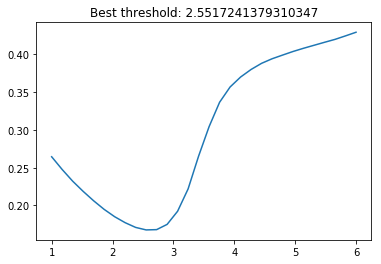

In [122]:
truth_class = np.zeros(len(pred))
truth_class[np.where(np.sum(signatures,axis=1) > 0.5)] += 1

thresholds = np.linspace(1,6,30)
errs = []
for t in thresholds:
    pred_class = np.zeros(len(pred))
    pred_class[np.where(np.max(pred,axis=1) > t)[0]] += 1
    errs.append(np.sum((pred_class - truth_class)**2)/len(truth_class)) 

best_threshold = thresholds[np.argmin(errs)]
plt.title("Best threshold: {}".format(best_threshold))
plt.plot(thresholds,errs)
plt.show()

In [123]:
pred_class = np.zeros(len(pred))
pred_class[np.where(np.max(pred,axis=1) > best_threshold)[0]] += 1

precision = len(np.where((pred_class == 1) & (truth_class == 1))[0]) / len(np.where((pred_class == 1))[0])
recall = len(np.where((pred_class == 1) & (truth_class == 1))[0]) / len(np.where(truth_class == 1)[0])
f1 = 2*precision*recall / (precision + recall)
acc = 1 - (np.sum((pred_class - truth_class)**2) / len(pred_class))
    
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)
print("Accuracy: ", acc)

Precision:  0.7786552803697233
Recall:  0.927674903678875
F1:  0.8466578965416196
Accuracy:  0.832350254707


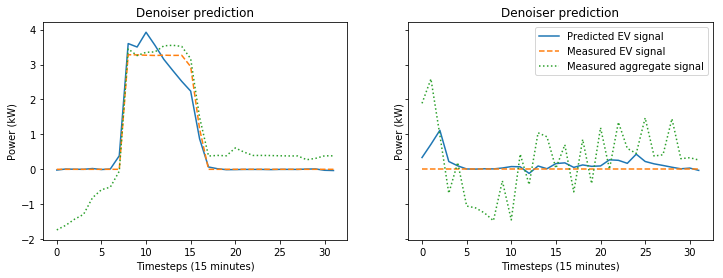

In [216]:
dice = np.random.randint(len(pred))
fig, ax = plt.subplots(1, 2, sharey='row')
fig.set_size_inches(12,4)

ax[0].plot(pred[dice], label="Predicted EV signal")
ax[0].plot(signatures[dice], ls='--', label="Measured EV signal")
ax[0].plot(signals[dice], ls=':', label="Measured aggregate signal")

dice = np.random.randint(len(pred))
ax[1].plot(pred[dice], label="Predicted EV signal")
ax[1].plot(signatures[dice], ls='--', label="Measured EV signal")
ax[1].plot(signals[dice], ls=':', label="Measured aggregate signal")

lgd = ax[1].legend(bbox_to_anchor=(1,1))
ax[0].set_title("Denoiser prediction")
ax[1].set_title("Denoiser prediction")
ax[0].set_xlabel("Timesteps (15 minutes)")
ax[1].set_xlabel("Timesteps (15 minutes)")
ax[0].set_ylabel("Power (kW)")
ax[1].set_ylabel("Power (kW)")
plt.savefig(fig_path + 'denoiser_prediction.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

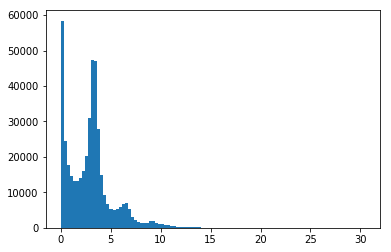

In [218]:
plt.hist(np.max(pred,axis=1),bins=100)
plt.show()

In [217]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 8)             40        
_________________________________________________________________
dense_1 (Dense)              (None, 32, 232)           2088      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 64)            14912     
_________________________________________________________________
dense_3 (Dense)              (None, 32, 232)           15080     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 1)             929       
Total params: 33,049
Trainable params: 33,049
Non-trainable params: 0
_________________________________________________________________
